### Goal

In this notebook, we explore fitting Gabor functions to provided RFs. This is particularly useful for fitting V1 RFs and characterizing their properties. Here, we use RF data obtained from [Taylor et al. 2024](https://www.biorxiv.org/content/10.1101/2024.05.12.593763v1#:~:text=We%20found%20that%20the%20model,prediction%20of%20the%20sensory%20future.).

In [1]:
import os
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import torch
import matplotlib.pyplot as plt

from brainbox.rfs.gabor import fit, query

%load_ext autoreload
%autoreload 2

In [2]:
# Load our example spatial RFs (shape: units x height x width)
gabor_rfs = torch.load(f"data/gabor_rfs.pt")

In [3]:
# Fit Gabor functions to each example RF
# Note: increasing the n_spectral_iterations and n_spatial_iterations variables 
# will result in a better fit.
if not os.path.exists(f"data/rf_fits/gabor.csv"):
    fit.GaborFitter().fit_spatial(f"data/rf_fits/gabor.csv", 
                                     gabor_rfs, 
                                     batch_size=100, 
                                     n_spectral_iterations=1000, 
                                     n_spatial_iterations=2000, 
                                     spectral_lr=10**-1.5, 
                                     spatial_lr=10**-2.5
                                 )

In [4]:
# Create a query object which gives us all the fit info
# Note: here the method expects strfs rather than rfs, so we include a temporal dimension
# by unsqueezeing the second dimension
fit_query = query.GaborQuery(f"data/rf_fits/gabor.csv", gabor_rfs.unsqueeze(1))

# We can now query the fit data - you can specify the minimum CC for each unit's RF fit
params_df, spatial_rfs, gabors, strfs, rfs2d = fit_query.validate(min_cc=0.7)

INFO:gabor:CC criteria exclusion 24
INFO:gabor:Location criteria exclusion 0
INFO:gabor:Envelope criteria exclusion 3


In [5]:
# The params_df gives us all the fitted Gabor paramters for each RF
params_df.head()

,x0,y0,sigmax,sigmay,theta,phi,frequency,cc
0,16.665503,5.628503,4.383598,3.147008,0.000000,1.286409,0.023786,0.758960
1,8.289160,7.960581,4.159885,2.480072,3.009549,3.141593,0.157389,0.808529
2,9.731340,8.497008,2.887225,1.465347,0.000000,1.469830,0.159300,0.865663
3,9.740035,10.091212,1.838227,0.976003,0.086721,0.839534,0.108249,0.886182
4,8.471981,6.467749,2.224756,4.018777,1.841823,2.345831,0.000000,0.829801


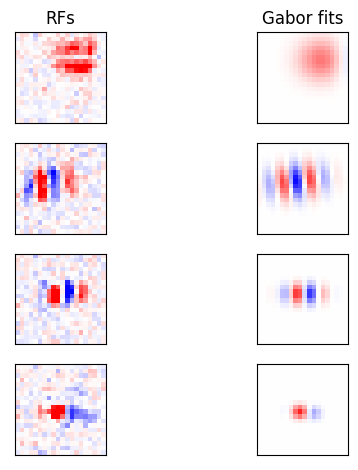

In [8]:
# The spatial_rfs and gabors tensor return our RFs and their fits which we can plot
def plot_rf_and_fit(i, ax):
    for j in range(2):
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
    axs[i, 0].imshow(spatial_rfs.detach()[i], vmin=-2, vmax=2, cmap="bwr")
    axs[i, 1].imshow(gabors.detach()[i], vmin=-1, vmax=1, cmap="bwr")

fig, axs = plt.subplots(4, 2)

plot_rf_and_fit(0, axs)
plot_rf_and_fit(1, axs)
plot_rf_and_fit(2, axs)
plot_rf_and_fit(3, axs)
axs[0, 0].set_title("RFs")
axs[0, 1].set_title("Gabor fits")
fig.tight_layout()